## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В задании требуется:  
Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

## Загрузка и обработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# Взглянем на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


Пропусков в датасете нет, тип столбцов соответсвует расположенному в них типу данных.

Посмотрим на основные статистические характеристики для каждого из признаков.

In [5]:
display(data.describe(include='all'))

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 42


Удалим дубликаты:

In [7]:
data = data.drop_duplicates()

In [8]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Дубликатов не обнаружено.

В датасете можно не принимать во внимание стоблцы salary	и salary_currency, т.к. у нас уже есть стоблец 	salary_in_usd, который позволит корректно сравнивать зарплаты между собой в одной валюте.

In [9]:
# Удалим стобцы, котоые не буем использовать
data = data.drop(labels=['salary','salary_currency'], axis=1)

In [10]:
# Проверим, что удаление прошло верно
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


In [11]:
display(data.head(1))

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L


Итак, имеем следующие признаки:  
 * категориальные: experience_level, employment_type, job_title, employee_residence, remote_ratio, 	company_location, company_size  
 * количественные: work_year, salary_in_usd

Теперь нужно определить, какие признаки влияют на уровень зарплаты у Data Scientist. Сделаем датасет для этой професии и посмотрим на распределение зарплат. 

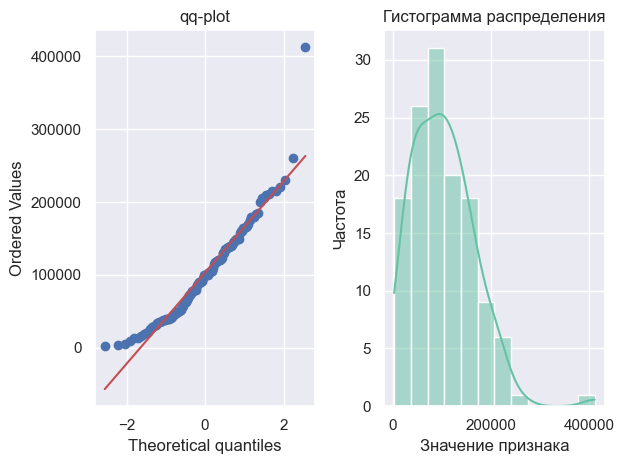

In [12]:
data_ds = data[data['job_title'] == 'Data Scientist']

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(data_ds['salary_in_usd'], plot=plt) # qq plot

plt.title('qq-plot')

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
#plt.hist(data_ds['salary_in_usd']) # гистограмма распределения признака
ax = sns.histplot(data_ds['salary_in_usd'], kde=True)
ax.set(xlabel='Значение признака', ylabel='Частота')
plt.title('Гистограмма распределения')
plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

Видим, что зарплаты распределены ненормально.

In [13]:
data_agg = data_ds['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат в долларах']
data_agg

,Размер зарплат в долларах
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


#### **Кодирование признаков**

Чтоб понять, какие признаки влияют на зарплату, необходимо создать матрицу кореляций. Но у нас есть категориальные признаки и мы не можем это сделать. Соответственно, предварительно необходимо их закодировать.

1) Для порядковых признаков используем порядковое кодирование (Ordinal Encoding). У нас это experience_level и company_size. Также сюда можно отнести remote_ratio.

In [14]:
display(data['remote_ratio'].value_counts())

remote_ratio
100    346
0      121
50      98
Name: count, dtype: int64

In [15]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[
    {
	'col': 'experience_level',
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 
                'EX': 4}
    },
    {
     'col': 'remote_ratio',
	'mapping': {0: 1, 50: 2, 100: 3}   
    },
    {
    'col': 'company_size',
	'mapping': {'S': 1, 'M': 2, 'L': 3}   
    }])
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data_ds[['experience_level','remote_ratio','company_size']])

# Переименуем исходные столбцы столбцы, чтоб после кодировки не довалиоись столбцы с таким же названием
data_ds = data_ds.rename(columns={'experience_level':'experience_level_notbin', 'company_size':'company_size_notbin', 'remote_ratio':'remote_ratio_notbin'})
#добавляем результат к исходному DataFrame
data_ds = pd.concat([data_ds, data_bin], axis=1)

data_ds
#display(data_bin)


,work_year,experience_level_notbin,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio_notbin,company_location,company_size_notbin,experience_level,remote_ratio,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,1,3
7,2020,MI,FT,Data Scientist,35735,HU,50,HU,L,2,2,3
10,2020,EN,FT,Data Scientist,51321,FR,0,FR,S,1,1,1
11,2020,MI,FT,Data Scientist,40481,IN,0,IN,L,2,1,3
12,2020,EN,FT,Data Scientist,39916,FR,0,FR,M,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022,SE,FT,Data Scientist,140400,US,0,US,M,3,1,2
570,2022,SE,FT,Data Scientist,210000,US,100,US,M,3,3,2
593,2022,SE,FT,Data Scientist,150000,US,100,US,M,3,3,2
598,2022,MI,FT,Data Scientist,160000,US,100,US,M,2,3,2


2) Для номинальных признаков, у которых мало занчений, используем метод кодирования "One Hot".
  У нас это признак employment_type. Признак work_year тоже можем закодировать, чтобы не было большого разброса в значениях данных(в остальных признаках значения от 0 до 4, а тут 2020-2022)


In [16]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['employment_type','work_year'], use_cat_names=True)
# применяем трансформацию к столбцу
type_bin = encoder.fit_transform(data_ds[['employment_type','work_year']])
#добавляем результат к исходному DataFrame
data_ds = pd.concat([data_ds, type_bin], axis=1)
data_ds

,work_year,experience_level_notbin,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio_notbin,company_location,company_size_notbin,experience_level,remote_ratio,company_size,employment_type_FT,employment_type_PT,employment_type_FL,work_year_2020.0,work_year_2021.0,work_year_2022.0
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,1,3,1,0,0,1,0,0
7,2020,MI,FT,Data Scientist,35735,HU,50,HU,L,2,2,3,1,0,0,1,0,0
10,2020,EN,FT,Data Scientist,51321,FR,0,FR,S,1,1,1,1,0,0,1,0,0
11,2020,MI,FT,Data Scientist,40481,IN,0,IN,L,2,1,3,1,0,0,1,0,0
12,2020,EN,FT,Data Scientist,39916,FR,0,FR,M,1,1,2,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022,SE,FT,Data Scientist,140400,US,0,US,M,3,1,2,1,0,0,0,0,1
570,2022,SE,FT,Data Scientist,210000,US,100,US,M,3,3,2,1,0,0,0,0,1
593,2022,SE,FT,Data Scientist,150000,US,100,US,M,3,3,2,1,0,0,0,0,1
598,2022,MI,FT,Data Scientist,160000,US,100,US,M,2,3,2,1,0,0,0,0,1


3) Для номинальных признаков с большим количеством занчений применим двоичное кодирование.  
У нас это признаки employee_residence и company_location.

In [17]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['employee_residence']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data_ds['employee_residence'])
data_ds = pd.concat([data_ds, type_bin], axis=1)

bin_encoder = ce.BinaryEncoder(cols=['company_location']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data_ds['company_location'])
data_ds = pd.concat([data_ds, type_bin], axis=1)


In [18]:
display(data_ds.head(1))

,work_year,experience_level_notbin,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio_notbin,company_location,company_size_notbin,experience_level,...,employee_residence_0,employee_residence_1,employee_residence_2,employee_residence_3,employee_residence_4,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,...,0,0,0,0,1,0,0,0,0,1


Итак, все признаки закодированы и представлены в виде числовых значений. Но разброс значений большой (зарплата в тысячах, а остальные признаки - 1 или 0), поэтому необъодимо нормализовать данные . Уже определили, что данные по зарплатам не распределены нормально, поэтому их нужно нормализовать. Предварительно от выбросов мы не очищали, поэтому используем метод RobustScaler.

In [19]:
from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный  стоблец датасета
data_ds['salary_in_usd'] = r_scaler.fit_transform(data_ds[['salary_in_usd']])




In [52]:
display(data_ds.info())

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 0 to 599
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   work_year                130 non-null    int64  
 1   experience_level_notbin  130 non-null    object 
 2   employment_type          130 non-null    object 
 3   job_title                130 non-null    object 
 4   salary_in_usd            130 non-null    float64
 5   employee_residence       130 non-null    object 
 6   remote_ratio_notbin      130 non-null    int64  
 7   company_location         130 non-null    object 
 8   company_size_notbin      130 non-null    object 
 9   experience_level         130 non-null    int64  
 10  remote_ratio             130 non-null    int64  
 11  company_size             130 non-null    int64  
 12  employment_type_FT       130 non-null    int64  
 13  employment_type_PT       130 non-null    int64  
 14  employment_type_FL       130 no

None

Посотрим что изменилось:

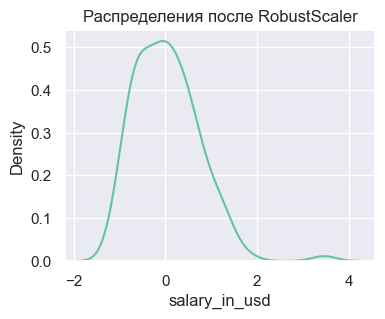

In [21]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(4, 3))
ax1.set_title('Распределения после RobustScaler')
sns.kdeplot(data_ds['salary_in_usd'], ax=ax1);

После нормализации значения признака стали от -2 до 4, но распределение все равно не нормальное, есть выбросы. Для оценки взаимосвязи признаков можем строить матрицу корреляций. Т.к. признаки в основном категориальные, а признак зарплаты не распределен нормально, используем ранговую корреляцию. Т.к. предварительно данные от выбросов не очищались, выберем коррелицию Кендалла.

In [22]:
data_ds[['work_year','salary_in_usd']].corr()

,work_year,salary_in_usd
work_year,1.00000,0.35692
salary_in_usd,0.35692,1.00000


<Axes: >

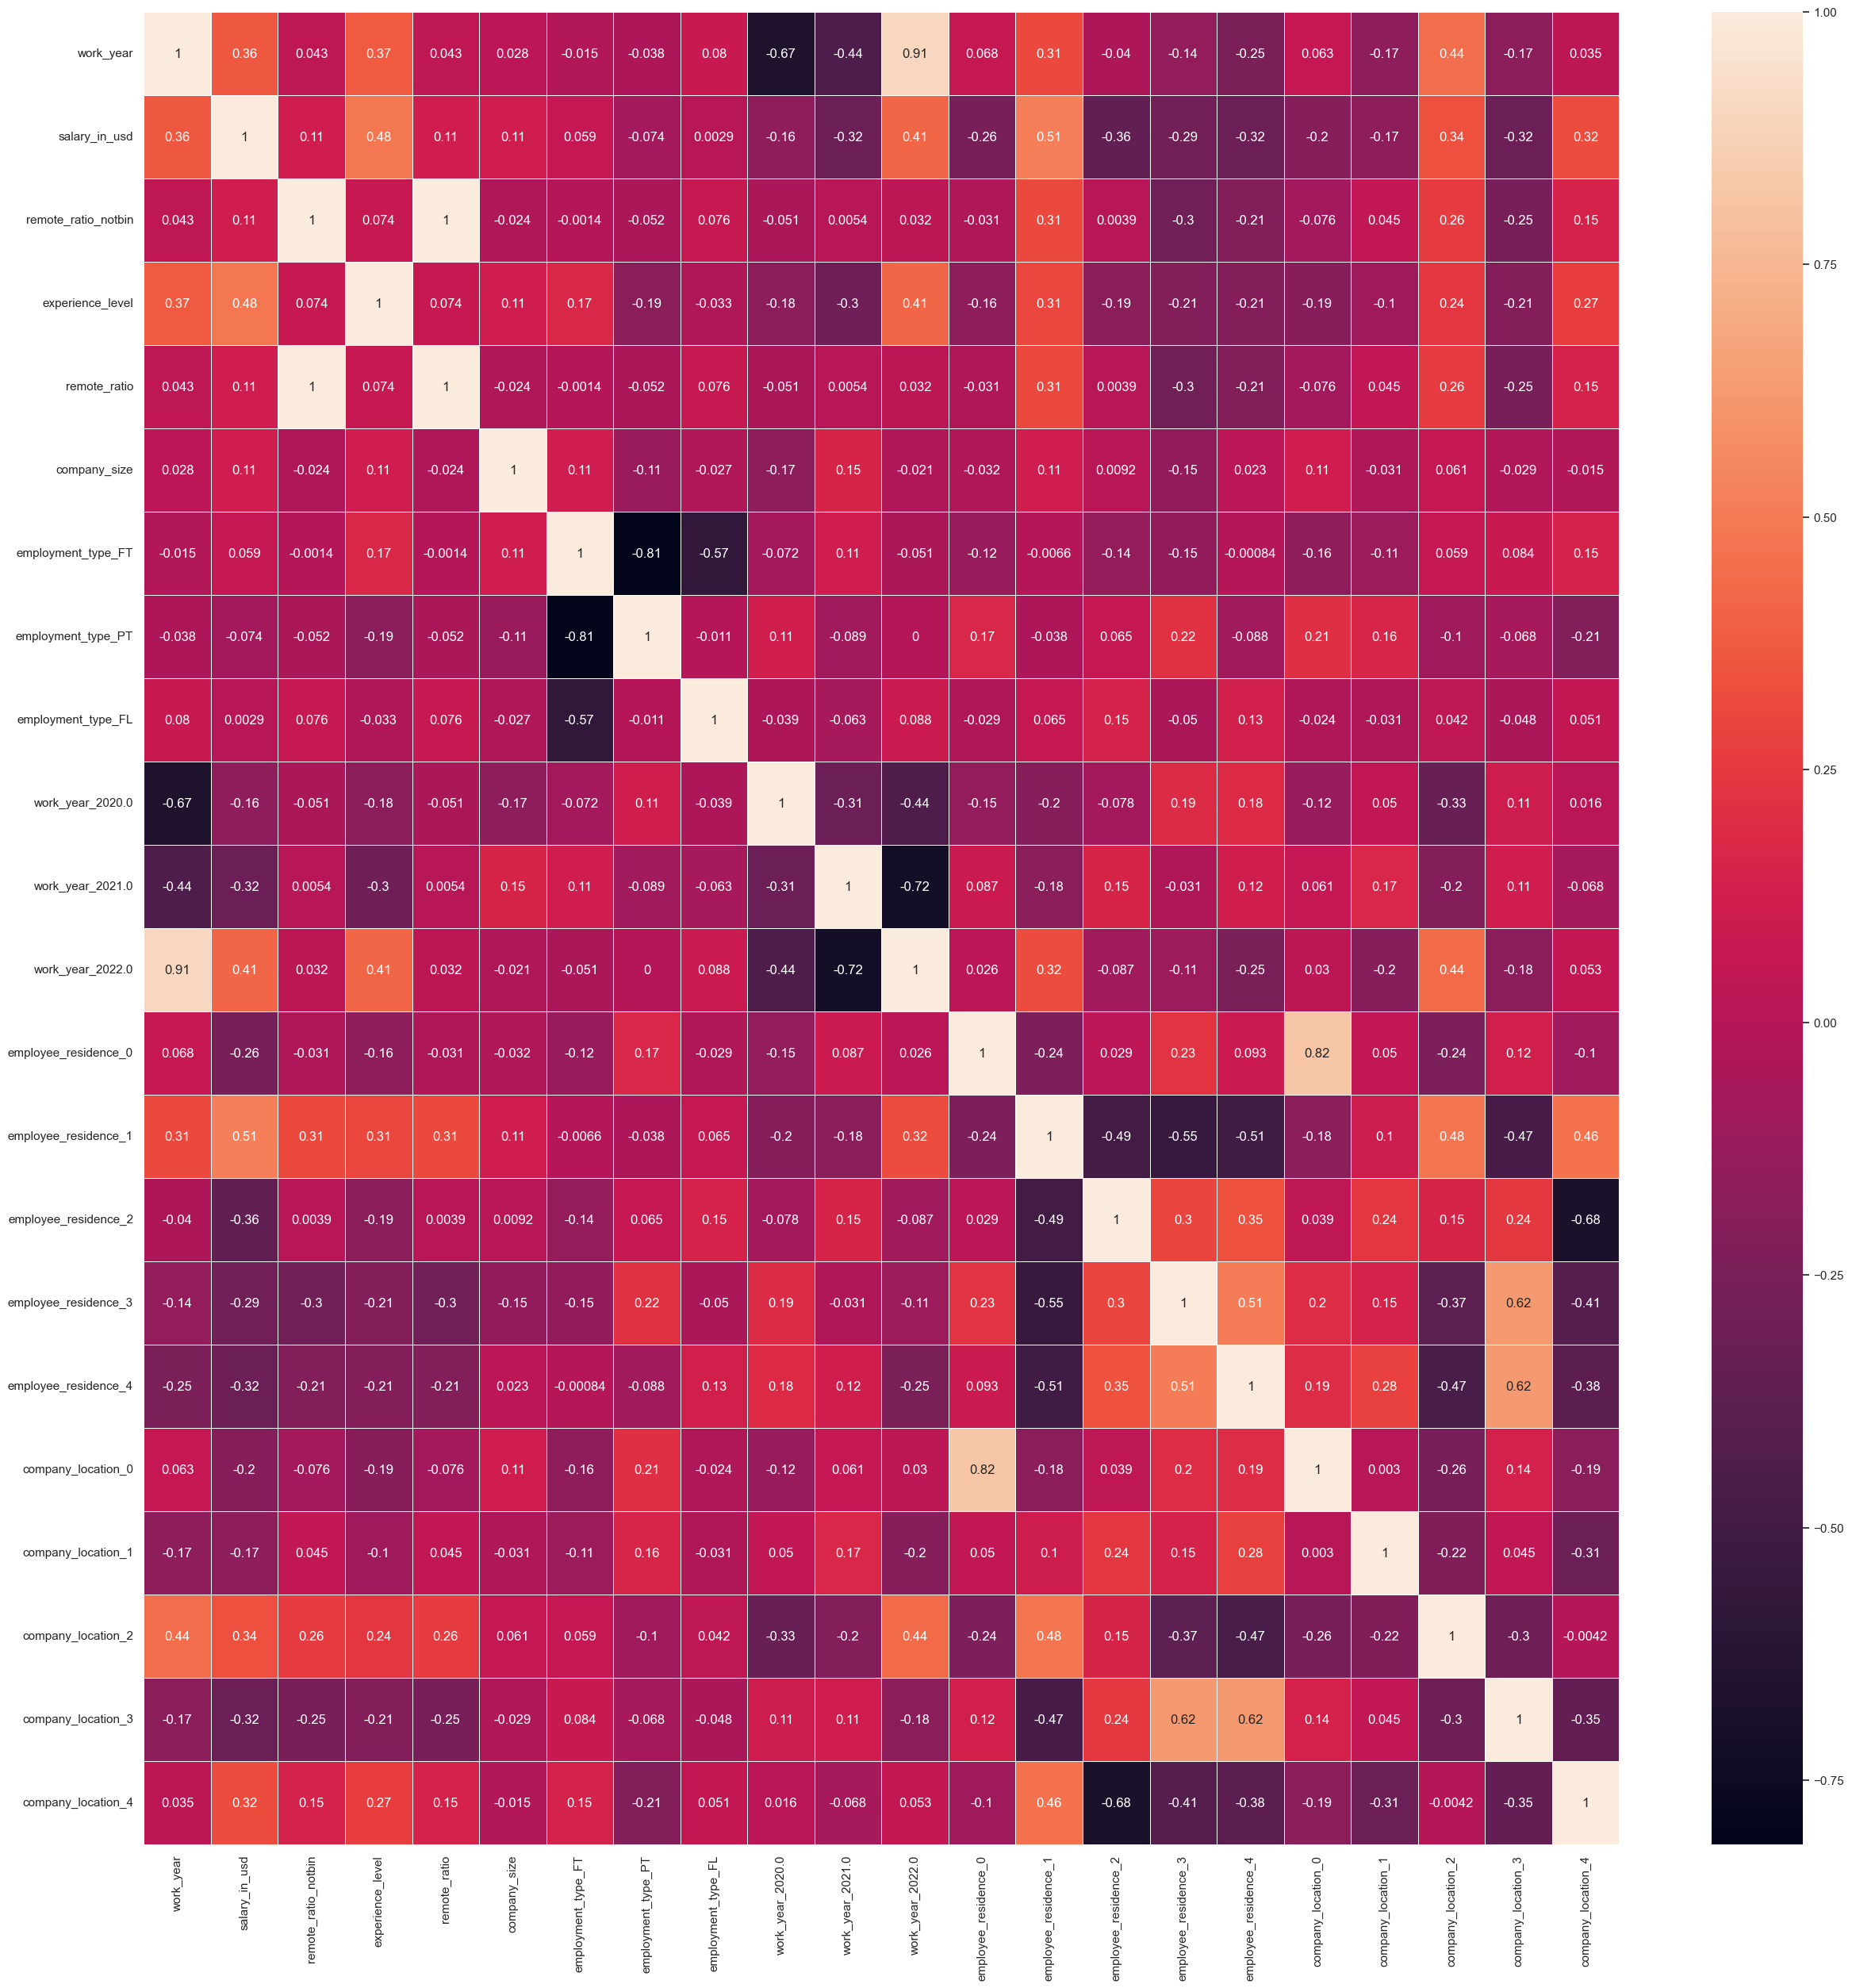

In [23]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data_ds.corr(numeric_only=True, method='kendall'), annot=True, linewidths=0.5)

**Вывод:** По матрице корреляций видим, что признак salary_in_usd (уровень зарплаты по специальности Data Scientist) имеет среднюю корреляцию с опытом работы на этой должности и страной проживания сотрудника, а также слабую корреляцию с годом работы и страной офиса работодателя. По корреляции Спирмена значения немного выше, но корреляция с теми же признаками.  
Теперь, когда мы знаем, с какими признаками коррелирует уровень зарплат, посмотрим на эти признаки более детально.

### Распределение зарплат в завиcимости от опыта работы

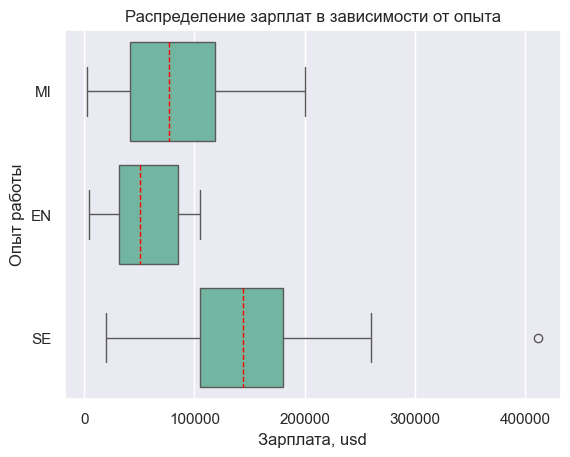

In [24]:
ax = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, usd', ylabel='Опыт работы')
plt.title('Распределение зарплат в зависимости от опыта')
plt.show()

In [25]:
data_agg = data[data['job_title'] == 'Data Scientist'].groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение зарплат в зависимости от опыта')
data_agg

Распределение зарплат в зависимости от опыта


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


Тут все логично, с опытом работы растет и зарплата.

### Распределение зарплат по стране проживания сотрудника

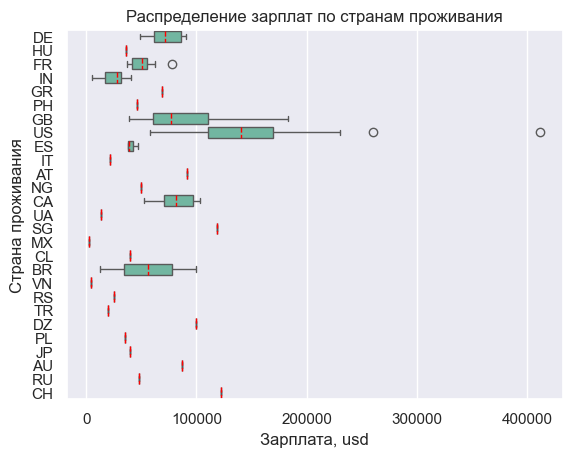

In [26]:
ax = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, usd', ylabel='Страна проживания')
plt.title('Распределение зарплат по странам проживания')
plt.show()

In [27]:
data_agg = data[data['job_title'] == 'Data Scientist'].groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values(by='mean',ascending=False).head(10)
print('Распределение зарплат по странам')
data_agg

Распределение зарплат по странам


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,66.0,147082.58,54499.36,58000.0,110500.00,140200.0,169250.00,412000.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
SG,1.0,119059.00,NaN,119059.0,119059.00,119059.0,119059.00,119059.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
GB,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
DE,6.0,72113.67,16752.86,49268.0,61781.75,71279.5,86448.75,90734.0


Визуально зарплата зависит от места проживания. Есть в торе спкие страны как Швейцария, Сингапур, но вывод сделать сложно, т.к. в этих странах всего по 1 вакансии, мало данных для вывода.

### Распределение зарплат по странам, где расположены офисы компаний

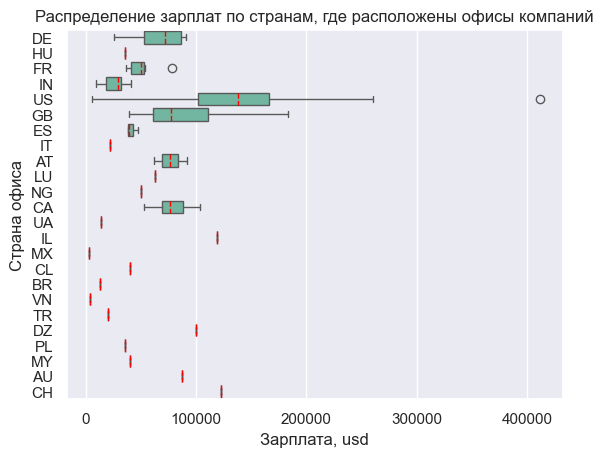

In [28]:
ax = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, usd', ylabel='Страна офиса')
plt.title('Распределение зарплат по странам, где расположены офисы компаний')
plt.show()

In [29]:
data_agg = data[data['job_title'] == 'Data Scientist'].groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values(by='mean',ascending=False).head(10)
print('Распределение зарплат по странам, где расположены офисы компаний')
data_agg

Распределение зарплат по странам, где расположены офисы компаний


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,66.0,147082.58,54499.36,58000.0,110500.00,140200.0,169250.00,412000.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
SG,1.0,119059.00,NaN,119059.0,119059.00,119059.0,119059.00,119059.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
GB,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
DE,6.0,72113.67,16752.86,49268.0,61781.75,71279.5,86448.75,90734.0


Распределение практически идентично распределению зарплат по странам проживания. Те же страны, те же цифры. Неудивительно, ведь корреляция этих признаков в одном их пересечений составляет 0.82.(После кодировки каждый признак разбился на 4-5, поэтому получилась целая таблица корреляций. Не совсем понятно, как в это случае определить корреляцию исходных признаков до кодировки).

### Распределение зарплат по годам

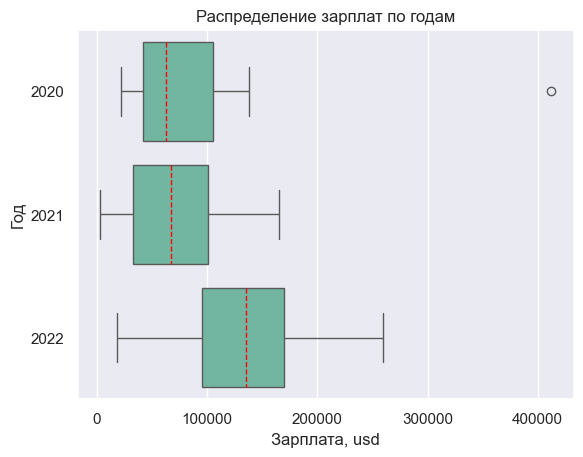

In [30]:
ax = sns.boxplot(data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, usd', ylabel='Год')
plt.title('Распределение зарплат по годам')
plt.show()

In [31]:
data_agg = data[data['job_title'] == 'Data Scientist'].groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение зарплат по годам')
data_agg

Распределение зарплат по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Видим, что в 2022 году зарплаты выросли. Позже проверим это на статистических тестах.

# Теперь ответим на ключевые вопросы HR-агентства

Предварительно создадим две функции, по которым будем принимат решения о нормальности распределения данных, а также об отклонении нулевой гипотезы

In [32]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

In [33]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### 1) Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): ежегодного роста зарплат у специалистов Data Scientist нет (за 2020, 2021 и 2022 годы соответственно).

$$ H_0 : (μ_1) => (μ_2) => (μ_3)$$

*Альтернативная гипотеза* ($H_1$):ежегодного зарплаты у специалистов Data Scientist растут.

$$ H_1 : (μ_1) <= (μ_2) <= (μ_3)$$

**Проверим признак зарплат на нормальность с помощью теста  Шапиро-Уилка.**

In [34]:
# Зарплаты по годам
salary_2020 = data_ds[data_ds['work_year'] == 2020]['salary_in_usd']
salary_2021 = data_ds[data_ds['work_year'] == 2021]['salary_in_usd']
salary_2022 = data_ds[data_ds['work_year'] == 2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])
print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])
print('2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выбираем тест**

Признак количественный.  
Группы 3.  
Группы независимы.  
Данные распределены ненормально(хотя бы один признак не распределен нормально).  
Выбираем критерий Краскела-Уоллиса.


**Проведем тест**

In [35]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

У специалистов Data Scientist наблюдается ежегодный рост зарплат.

### 2) Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): В 2022 году зарплаты у специалистов Data Scientist ($μ_1$) меньше или равны зарплатам у Data Engineer($μ_2$).

$$ H_0 : (μ_1) <= (μ_2)$$

*Альтернативная гипотеза* ($H_1$): В 2022 году зарплаты у специалистов Data Scientist ($μ_1$) больше зарплат у Data Engineer($μ_2$).

$$ H_1 : (μ_1) > (μ_2)$$

**Проверим признак на нормальность**

In [36]:
# Зарплаты по профессиям
DS = data[(data['job_title'] == 'Data Scientist') & (data['work_year'] == 2022)]['salary_in_usd']
DE = data[(data['job_title'] == 'Data Engineer') & (data['work_year'] == 2022)]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Scientist:')
result = stats.shapiro(DS)
decision_normality(result[1])
print('Data Engineer:')
result = stats.shapiro(DE)
decision_normality(result[1])

Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем тест**

Признак количественный.  
Группы 2.  
Группы независимы.  
Данные в одном признаке распределены ненормально.  
Выбираем U-критерий Манна-Уитни.


**Проводим тест**

In [37]:
# проводим тест
_, p = stats.mannwhitneyu(DS, DE, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** 

У нас нет оснований полагать, что в 2022 году зарплата DS больше, чем у DE. Но значение p-value = 0.077 при такой версии альтернативной гипотезы, что близко к уровню значимости альфа. Если принять большее допущение альфа, то в принципе можно будет отвергнуть нулевую гипотезу и сказать, что зарплаты DS больше.  
Это косвенно подтверждается, если перевернуть гипотезы, например в качестве нулевой гипотезы сказать, что $$ (μ_1) => (μ_2)$$, а в качестве Альтернативной $$(μ_1) < (μ_2)$$, и в параметре alternative указать 'less', то p-value = 0.923, что говрит о том, что зарплаты DE совершенно не больше, чем у DS.

### 3) Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты у специалистов Data Scientist в компаниях различных размеров равны.

$$ H_0 : (μ_1) = (μ_2) = (μ_3)$$

*Альтернативная гипотеза* ($H_1$): Зарплаты у специалистов Data Scientist в компаниях различных размеров не равны.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверим признак на нормальность**

In [38]:
# Зарплаты по размерам компаний
company_s = data[(data['company_size'] == 'S')]['salary_in_usd']
company_m = data[(data['company_size'] == 'M')]['salary_in_usd']
company_l = data[(data['company_size'] == 'L')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('company_s:')
result = stats.shapiro(company_s)
decision_normality(result[1])
print('company_m:')
result = stats.shapiro(company_m)
decision_normality(result[1])
print('company_l:')
result = stats.shapiro(company_l)
decision_normality(result[1])

company_s:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
company_m:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
company_l:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем тест**

Признак количественный.  
Группы 3.  
Группы независимы.  
Данные распределены ненормально.  
Выбираем критерий Краскела-Уоллиса.


In [39]:
# проводим тест
_, p = stats.kruskal(company_s, company_m, company_l)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** 

Выбираем альтернативную гипотезу. Зарплаты у специалистов Data Scientist в компаниях различных размеров не равны.

### 4) Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): связи между наличием должностей Data Scientist и Data Engineer и размером компании нет.


*Альтернативная гипотеза* ($H_1$): связь между наличием должностей Data Scientist и Data Engineer и размером компании есть.


Подготовим данные. Создадим столбец с профессиями c интересующими нас профессиями, а отстальные объединим в отдельную группу.

In [40]:
data['DSDE'] = data['job_title'].apply(lambda x: x if x in ['Data Scientist','Data Engineer'] else 'Other')

In [41]:
display(data['DSDE'].value_counts())

DSDE
Other             314
Data Scientist    130
Data Engineer     121
Name: count, dtype: int64

**Выбираем тест**

Признаки категориальные, не связанные, категории две, поэтому выбираем тест Критерий хи-квадрат.

In [42]:
# вычисляем таблицу сопряжённости
table = pd.crosstab(data['company_size'], data['DSDE'])
table

DSDE,Data Engineer,Data Scientist,Other
company_size,,,
L,34,43,116
M,81,66,143
S,6,21,55


**Проводим тест**

In [43]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Принимаем альтернативную гипотезу. Связь между наличием должностей Data Scientist и Data Engineer и размером компании есть.

**А теперь проверим то же самое, но без категории 'Other'**

In [44]:
# вычисляем таблицу сопряжённости
table = pd.crosstab(data['company_size'], data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]['job_title'])
table


job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


In [45]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** 

Указанные признаки точно зависимы.

### 5) Доп. вопрос. Средняя зарплата специалистов Data Engeneer равна 150 000 рублей?

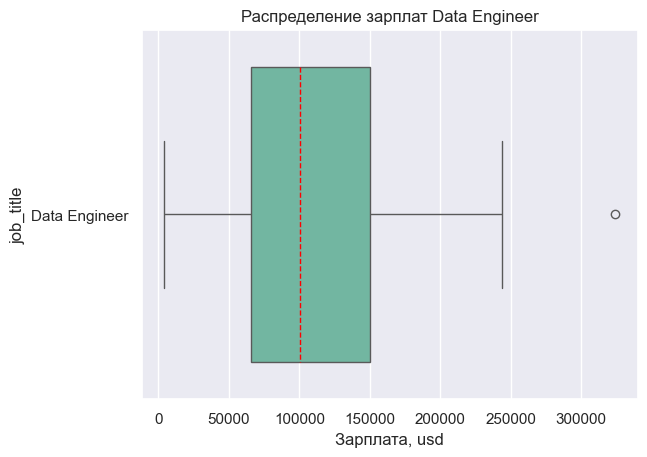

In [46]:
ax = sns.boxplot( data[data['job_title'] == 'Data Engineer'], x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, usd')
plt.title('Распределение зарплат Data Engineer')
plt.show()

Визуально медианное значение около 110 000, проверим наш вопрос на статистическом тесте.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата специалистов Data Engeneer($μ_1$) равна 120 000 рублей.

$$ H_0 : (μ_1) = 120 000 $$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата специалистов Data Engeneer не равна 120 000 рублей.

$$ H_1 : (μ_1) \neq 120 000 $$

**Проверим распределение на нормальность**

In [47]:
# Зарплаты по размерам компаний
DE_salary = data[data['job_title'] == 'Data Engineer']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Engineer salary:')
result = stats.shapiro(DE_salary)
decision_normality(result[1])

Data Engineer salary:
p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем тест**

Признак количественный.  
Группа 1.    
Данные распределены ненормально.  
Выбираем критерий знаков (для одной выборки).

**Проводим тест**

In [48]:
from statsmodels.stats.descriptivestats import sign_test

# проводим тест
_, p = sign_test(DE_salary, 120000)
decision_hypothesis(p)

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Видим, что средняя зарплата не равна 120 000. Попробуем сдвинуть зарплату на 100 000.

In [49]:
_, p = sign_test(DE_salary, 100000)
decision_hypothesis(p)

p-value = 0.855
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** 

Гипотеза о том, что медианная зарплата Data Engineer равна 120 000 оказалась неверна. А вот если снизить ожидаемую зарпату до 100 000, то оснований отвергнуть это у нас нет.

### 6) Доп. вопрос. Проверим ту гипотезу, полученную при составлении матрицы корреляций. А именно мы получили информацию, что признак salary_in_usd (уровень зарплаты по специальности Data Scientist) имеет среднюю корреляцию со страной проживания сотрудника.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): связи между зарплатой по специальности Data Scientist и страной проживания сотрудника нет.


*Альтернативная гипотеза* ($H_1$): связь между зарплатой по специальности Data Scientist и страной проживания сотрудника есть.


**Выбираем тест**

Признаки категориальные, не связанные, категории две, поэтому выбираем тест Критерий хи-квадрат.

**Вычисляем таблицу сопряженности:**

In [50]:
table = pd.crosstab(data[data['job_title'] == 'Data Scientist']['salary_in_usd'], data['employee_residence'])
table

employee_residence,AT,AU,BR,CA,CH,CL,DE,DZ,ES,FR,...,NG,PH,PL,RS,RU,SG,TR,UA,US,VN
salary_in_usd,,,,,,,,,,,,,,,,,,,,,
2859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12901,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
220000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
230000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**Проводим тест**

In [51]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

Признаки запрплаты и место проживания сотрудника по специальности Data Scientist взаимосвязаны.

## **Общий вывод по работе**

Итак, проделана большая работа, возможно больше чем требовалось в задании, а возможно меньше, на мой взгляд точной логики между  вопросами задания и системой оценки нет(скорее всего я не понял точно, что нужно было делать:)), но тем не менее, датасет о зарплатах в сфере Data Science за 2020–2022 годы был выгружен, проверен на пропуски и дубликаты.  Был найден ответ на вопрос, какие признаки влияют на уровень зарплат по специальности Data Scientist. Для этого сначала были удалены неинформитивные признаки, затем категориальные признаки были закодированы, а количественный признак зарплаты был нормализован (для соответстия масштабу измерения остальных данных) и построена матрица корреляций. По ней были определены признаки, влияющие на зарплату: опыт работы на этой должности, страна проживания сотрудника, год работы и страна офиса работодателя. Часть этих корелляций была проверенана на статистическую значимость с помощью статичтических тестов.  
    Также с помощью статистических тестов были найдены ответы на вопросы HR-агенства.

**P.S. Осталась пара вопросов, здорово, если ответите**
1) как рассчитать корреляцию Мэтьюса для всего датасета? Я закодировал почти весь датасет, признаки стали бинарными, вроде корреляция Мэтьюса должна подойти, но там просит x и Y.(т.е. два признака, а у меня датасет) И numeric_only не поддерживает этот метод.

2) как рассчитать корреляцию в этом случае
data_ds[['employee_residence','company_location']].corr(method = 'kendall')
если признаки стран закодировать, получается много столбцов, целая матрица корреляции 5х5, и значения от 0.012 до 0.82.
И как понимать, есть ли между этими признаками корреляция или нет?

3) Вопрос по тестам с одной группой
В тесте одновыборочного Т-критерия можно проверить условие <=, т.к. есть аргумент 'alternative'.
А в аналоге это теста критерии знаков получается можно проверить условие только равно? 
Тк он не имеет этого аргумента (sign_test() got an unexpected keyword argument 'alternative'). 
Я вот в вопросе номер 5 хотел проверить "Средняя зарплата специалистов Data Engeneer больше 150 000 рублей?", но пришлось проверять только "Средняя зарплата специалистов Data Engeneer равна 150 000 рублей?"

4) Соответственно и в вопросе №3 "Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?" я могу проверить только m1=m2=m3 или m1!= m2 != m3. Условие например m1<m2<m3 я не проверю. Или не так понимаю? 